## Plotting trap average to seasonal water column distributions

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import jensenshannon
from scipy.interpolate import interp1d

Importing data

In [2]:
water_SM = pd.read_csv('../../data/LISST/corrected_GSDs/SM23_WC_normalized_GSD_corrected.csv')
trap_SM = pd.read_csv('../../data/sediment_traps/SM23_trap_normalized_GSD_LISST.csv')
water_SP = pd.read_csv('../../data/LISST/corrected_GSDs/SP23_WC_normalized_GSD_corrected.csv')
trap_SP = pd.read_csv('../../data/sediment_traps/SP23_trap_normalized_GSD_LISST.csv')

# getting information
grain_sizes = np.array(water_SM.iloc[:, 0])
water_SM_array = np.array(water_SM.iloc[:, 1:]) # spring water column
trap_SM_array = np.array(trap_SM.iloc[:, 1:]) # spring sediment traps
water_SP_array = np.array(water_SP.iloc[:, 1:]) # summer water column
trap_SP_array = np.array(trap_SP.iloc[:, 1:]) # summer sediment traps
# only closed traps
trap_SM_array = trap_SM_array[:, np.array([col.endswith(('A', 'D')) for col in trap_SM.columns[1:]])]
trap_SP_array = trap_SP_array[:, np.array([col.endswith(('A', 'D')) for col in trap_SP.columns[1:]])]
# also keep grain size column
trap_SM = trap_SM.loc[:, (trap_SM.columns == trap_SM.columns[0]) | trap_SM.columns.str.endswith(('A', 'D'))]
trap_SP = trap_SP.loc[:, (trap_SP.columns == trap_SP.columns[0]) | trap_SP.columns.str.endswith(('A', 'D'))]

PDF Calculations

In [3]:
# calculating max, avg and min GSDs of the water columns
spring_wc_gsd_max = pd.DataFrame(np.max(water_SP_array, axis=1))
spring_wc_gsd_avg = pd.DataFrame(np.mean(water_SP_array, axis=1))
spring_wc_gsd_min = pd.DataFrame(np.min(water_SP_array, axis=1))
summer_wc_gsd_max = pd.DataFrame(np.max(water_SM_array, axis=1))
summer_wc_gsd_avg = pd.DataFrame(np.mean(water_SM_array, axis=1))
summer_wc_gsd_min = pd.DataFrame(np.min(water_SM_array, axis=1))
# calculating max, avg and min GSDs of the baskets
spring_st_gsd_max = pd.DataFrame(np.max(trap_SP_array, axis=1))
spring_st_gsd_avg = pd.DataFrame(np.mean(trap_SP_array, axis=1))
spring_st_gsd_min = pd.DataFrame(np.min(trap_SP_array, axis=1))
summer_st_gsd_max = pd.DataFrame(np.max(trap_SM_array, axis=1))
summer_st_gsd_avg = pd.DataFrame(np.mean(trap_SM_array, axis=1))
summer_st_gsd_min = pd.DataFrame(np.min(trap_SM_array, axis=1))

# calculating standard deviations of water columns and traps
spring_wc_gsd_std = pd.DataFrame(np.std(water_SP_array, axis=1))
summer_wc_gsd_std = pd.DataFrame(np.std(water_SM_array, axis=1))
spring_st_gsd_std = pd.DataFrame(np.std(trap_SP_array, axis=1))
summer_st_gsd_std = pd.DataFrame(np.std(trap_SM_array, axis=1))

# calculating percentiles of the water columns 
spring_wc_gsd_d90 = pd.DataFrame(np.percentile(water_SP_array, 90, axis=1))
spring_wc_gsd_d10 = pd.DataFrame(np.percentile(water_SP_array, 10, axis=1))
summer_wc_gsd_d90 = pd.DataFrame(np.percentile(water_SM_array, 90, axis=1))
summer_wc_gsd_d10 = pd.DataFrame(np.percentile(water_SM_array, 10, axis=1))
# calculating percentiles of the sediment traps
spring_st_gsd_d90 = pd.DataFrame(np.percentile(trap_SP_array, 90, axis=1))
spring_st_gsd_d10 = pd.DataFrame(np.percentile(trap_SP_array, 10, axis=1))
summer_st_gsd_d90 = pd.DataFrame(np.percentile(trap_SM_array, 90, axis=1))
summer_st_gsd_d10 = pd.DataFrame(np.percentile(trap_SM_array, 10, axis=1))


In [4]:
# add max, avg, std and min GSDs to the dataframes as new columns
water_SP["max"] = spring_wc_gsd_max
water_SP["avg"] = spring_wc_gsd_avg
water_SP["min"] = spring_wc_gsd_min
water_SP["std"] = spring_wc_gsd_std
water_SM["max"] = summer_wc_gsd_max
water_SM["avg"] = summer_wc_gsd_avg
water_SM["min"] = summer_wc_gsd_min
water_SM["std"] = summer_wc_gsd_std

trap_SP['max'] = spring_st_gsd_max
trap_SP['avg'] = spring_st_gsd_avg
trap_SP['min'] = spring_st_gsd_min
trap_SP['std'] = spring_st_gsd_std
trap_SM['max'] = summer_st_gsd_max
trap_SM['avg'] = summer_st_gsd_avg
trap_SM['min'] = summer_st_gsd_min
trap_SM['std'] = summer_st_gsd_std

# adding the percentiles to the dataframes as well
water_SP['d90'] = spring_wc_gsd_d90
water_SP['d10'] = spring_wc_gsd_d10
water_SM['d90'] = summer_wc_gsd_d90
water_SM['d10'] = summer_wc_gsd_d10
trap_SP['d90'] = spring_st_gsd_d90
trap_SP['d10'] = spring_st_gsd_d10
trap_SM['d90'] = summer_st_gsd_d90
trap_SM['d10'] = summer_st_gsd_d10

In [5]:
# loop to delete all variables that start with "summer" and "spring"
for var in list(globals().keys()):
    if var.startswith("summer") or var.startswith("spring"):
        del globals()[var]

CDF calculations

In [6]:
# transforming all PDF data to CDF 
# Use axis=0 to cumsum down the rows (across grain sizes) for each sample
water_SM_cdf_array = water_SM_array.cumsum(axis=0)
trap_SM_cdf_array = trap_SM_array.cumsum(axis=0)
water_SP_cdf_array = water_SP_array.cumsum(axis=0)
trap_SP_cdf_array = trap_SP_array.cumsum(axis=0)

# create DataFrames with grain sizes as the first column
water_SM_cdf = pd.DataFrame(water_SM_cdf_array, columns=water_SM.columns[1:-6])  # skip first column name and ignore last six
water_SM_cdf.insert(0, water_SM.columns[0], grain_sizes)  # insert grain sizes as first column
water_SP_cdf = pd.DataFrame(water_SP_cdf_array, columns=water_SP.columns[1:-6])
water_SP_cdf.insert(0, water_SP.columns[0], grain_sizes)
trap_SM_cdf = pd.DataFrame(trap_SM_cdf_array, columns=trap_SM.columns[1:-6])
trap_SM_cdf.insert(0, trap_SM.columns[0], grain_sizes)
trap_SP_cdf = pd.DataFrame(trap_SP_cdf_array, columns=trap_SP.columns[1:-6])
trap_SP_cdf.insert(0, trap_SP.columns[0], grain_sizes)

In [7]:
# calculating max, avg and min GSDs of the water columns
spring_wc_gsd_max = pd.DataFrame(np.max(water_SP_cdf_array, axis=1))
spring_wc_gsd_avg = pd.DataFrame(np.mean(water_SP_cdf_array, axis=1))
spring_wc_gsd_min = pd.DataFrame(np.min(water_SP_cdf_array, axis=1))
summer_wc_gsd_max = pd.DataFrame(np.max(water_SM_cdf_array, axis=1))
summer_wc_gsd_avg = pd.DataFrame(np.mean(water_SM_cdf_array, axis=1))
summer_wc_gsd_min = pd.DataFrame(np.min(water_SM_cdf_array, axis=1))
# calculating max, avg and min GSDs of the baskets
spring_st_gsd_max = pd.DataFrame(np.max(trap_SP_cdf_array, axis=1))
spring_st_gsd_avg = pd.DataFrame(np.mean(trap_SP_cdf_array, axis=1))
spring_st_gsd_min = pd.DataFrame(np.min(trap_SP_cdf_array, axis=1))
summer_st_gsd_max = pd.DataFrame(np.max(trap_SM_cdf_array, axis=1))
summer_st_gsd_avg = pd.DataFrame(np.mean(trap_SM_cdf_array, axis=1))
summer_st_gsd_min = pd.DataFrame(np.min(trap_SM_cdf_array, axis=1))

# calculating standard deviations of water columns and traps
spring_wc_gsd_std = pd.DataFrame(np.std(water_SP_cdf_array, axis=1))
summer_wc_gsd_std = pd.DataFrame(np.std(water_SM_cdf_array, axis=1))
spring_st_gsd_std = pd.DataFrame(np.std(trap_SP_cdf_array, axis=1))
summer_st_gsd_std = pd.DataFrame(np.std(trap_SM_cdf_array, axis=1))

# calculating percentiles of the water columns 
spring_wc_gsd_d90 = pd.DataFrame(np.percentile(water_SP_cdf_array, 90, axis=1))
spring_wc_gsd_d10 = pd.DataFrame(np.percentile(water_SP_cdf_array, 10, axis=1))
summer_wc_gsd_d90 = pd.DataFrame(np.percentile(water_SM_cdf_array, 90, axis=1))
summer_wc_gsd_d10 = pd.DataFrame(np.percentile(water_SM_cdf_array, 10, axis=1))
# calculating percentiles of the sediment traps
spring_st_gsd_d90 = pd.DataFrame(np.percentile(trap_SP_cdf_array, 90, axis=1))
spring_st_gsd_d10 = pd.DataFrame(np.percentile(trap_SP_cdf_array, 10, axis=1))
summer_st_gsd_d90 = pd.DataFrame(np.percentile(trap_SM_cdf_array, 90, axis=1))
summer_st_gsd_d10 = pd.DataFrame(np.percentile(trap_SM_cdf_array, 10, axis=1))


In [8]:
# add max, avg, std and min GSDs to the dataframes as new columns
water_SP_cdf["max"] = spring_wc_gsd_max
water_SP_cdf["avg"] = spring_wc_gsd_avg
water_SP_cdf["min"] = spring_wc_gsd_min
water_SP_cdf["std"] = spring_wc_gsd_std
water_SM_cdf["max"] = summer_wc_gsd_max
water_SM_cdf["avg"] = summer_wc_gsd_avg
water_SM_cdf["min"] = summer_wc_gsd_min
water_SM_cdf["std"] = summer_wc_gsd_std

trap_SP_cdf['max'] = spring_st_gsd_max
trap_SP_cdf['avg'] = spring_st_gsd_avg
trap_SP_cdf['min'] = spring_st_gsd_min
trap_SP_cdf['std'] = spring_st_gsd_std
trap_SM_cdf['max'] = summer_st_gsd_max
trap_SM_cdf['avg'] = summer_st_gsd_avg
trap_SM_cdf['min'] = summer_st_gsd_min
trap_SM_cdf['std'] = summer_st_gsd_std

# adding the percentiles to the dataframes as well
water_SP_cdf['d90'] = spring_wc_gsd_d90
water_SP_cdf['d10'] = spring_wc_gsd_d10
water_SM_cdf['d90'] = summer_wc_gsd_d90
water_SM_cdf['d10'] = summer_wc_gsd_d10
trap_SP_cdf['d90'] = spring_st_gsd_d90
trap_SP_cdf['d10'] = spring_st_gsd_d10
trap_SM_cdf['d90'] = summer_st_gsd_d90
trap_SM_cdf['d10'] = summer_st_gsd_d10

In [9]:
# loop to delete all variables that start with "summer" and "spring" and end with "array"
for var in list(globals().keys()):
    if var.startswith("summer") or var.startswith("spring"):
        del globals()[var]
    if var.endswith('array'):
        del globals()[var]

## Plots

In [10]:
trap_SM_full = pd.read_csv('trap_full_dist/trap_SM_interpolated_kde.csv')
trap_SP_full = pd.read_csv('trap_full_dist/trap_SP_interpolated_kde.csv')
bedload_SP_full = pd.read_csv('trap_full_dist/bedload_interpolated_kde.csv')
trap_SM_coarse = pd.read_csv('trap_full_dist/trap_SM_coarse_interpolated_kde.csv')
trap_SP_coarse = pd.read_csv('trap_full_dist/trap_SP_coarse_interpolated_kde.csv')

# convert from pdf to cdf, do not sum for the first column
trap_SM_full_cdf = pd.concat([trap_SM_full.iloc[:, [0]], trap_SM_full.iloc[:, 1:].cumsum(axis=0, skipna=True)], axis=1)
trap_SP_full_cdf = pd.concat([trap_SP_full.iloc[:, [0]], trap_SP_full.iloc[:, 1:].cumsum(axis=0, skipna=True)], axis=1)
trap_SM_coarse_cdf = pd.concat([trap_SM_coarse.iloc[:, [0]], trap_SM_coarse.iloc[:, 1:].cumsum(axis=0, skipna=True)], axis=1)
trap_SP_coarse_cdf = pd.concat([trap_SP_coarse.iloc[:, [0]], trap_SP_coarse.iloc[:, 1:].cumsum(axis=0, skipna=True)], axis=1)
bedload_cdf = pd.concat([bedload_SP_full.iloc[:, [0]], bedload_SP_full.iloc[:, 1:].cumsum(axis=0, skipna=True)], axis=1)

# determine the arrays
grain_sizes_full = np.array(trap_SM_full_cdf.iloc[:, 0]) # full grain sizes
trap_SM_full_array = np.array(trap_SM_full_cdf.iloc[:, 1:]) # full sediment traps
trap_SP_full_array = np.array(trap_SP_full_cdf.iloc[:, 1:]) # full sediment traps

grain_sizes_coarse = np.array(trap_SM_coarse_cdf.iloc[:, 0]) # coarse grain sizes
trap_SM_coarse_array = np.array(trap_SM_coarse_cdf.iloc[:, 1:]) # coarse sediment traps
trap_SP_coarse_array = np.array(trap_SP_coarse_cdf.iloc[:, 1:]) # coarse sediment traps

bedload_grain_sizes = np.array(bedload_cdf.iloc[:, 0]) # bedload grain sizes
bedload_array = np.array(bedload_cdf.iloc[:, 1:]) # bedload sediment traps

# only keep closed traps
trap_SM_full_array = trap_SM_full_array[:, np.array([col.endswith(('A_interpolated_kde', 'D_interpolated_kde')) for col in trap_SM_full_cdf.columns[1:]])]
trap_SP_full_array = trap_SP_full_array[:, np.array([col.endswith(('A_interpolated_kde', 'D_interpolated_kde')) for col in trap_SP_full_cdf.columns[1:]])]
trap_SM_coarse_array = trap_SM_coarse_array[:, np.array([col.endswith(('A_interpolated_kde', 'D_interpolated_kde')) for col in trap_SM_coarse_cdf.columns[1:]])]
trap_SP_coarse_array = trap_SP_coarse_array[:, np.array([col.endswith(('A_interpolated_kde', 'D_interpolated_kde')) for col in trap_SP_coarse_cdf.columns[1:]])]
# and also keep grain size column
trap_SM_full_cdf = trap_SM_full_cdf.loc[:, (trap_SM_full_cdf.columns == trap_SM_full_cdf.columns[0]) | trap_SM_full_cdf.columns.str.endswith(('A_interpolated_kde', 'D_interpolated_kde'))]
trap_SP_full_cdf = trap_SP_full_cdf.loc[:, (trap_SP_full_cdf.columns == trap_SP_full_cdf.columns[0]) | trap_SP_full_cdf.columns.str.endswith(('A_interpolated_kde', 'D_interpolated_kde'))]
trap_SM_coarse_cdf = trap_SM_coarse_cdf.loc[:, (trap_SM_coarse_cdf.columns == trap_SM_coarse_cdf.columns[0]) | trap_SM_coarse_cdf.columns.str.endswith(('A_interpolated_kde', 'D_interpolated_kde'))]
trap_SP_coarse_cdf = trap_SP_coarse_cdf.loc[:, (trap_SP_coarse_cdf.columns == trap_SP_coarse_cdf.columns[0]) | trap_SP_coarse_cdf.columns.str.endswith(('A_interpolated_kde', 'D_interpolated_kde'))]

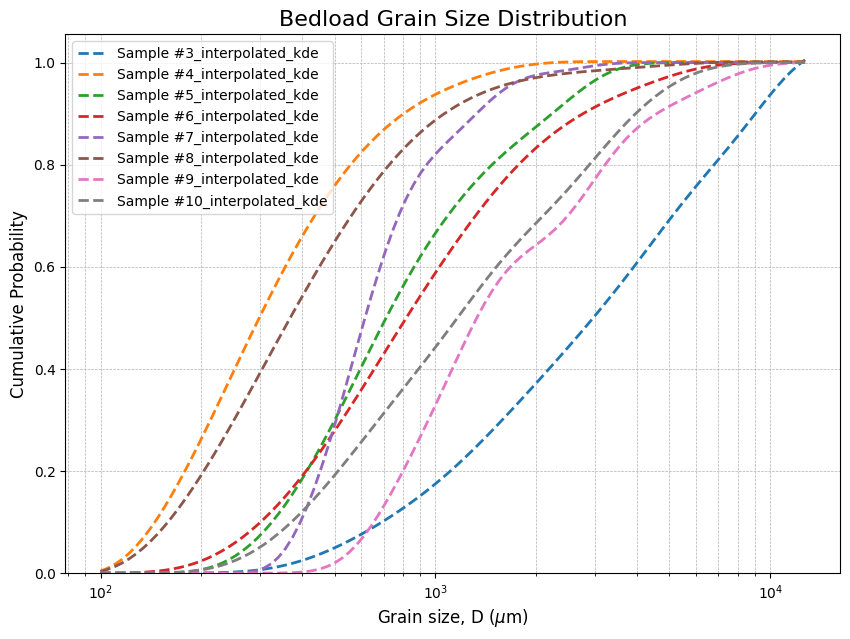

In [11]:
# plot all bedload cdfs samples
fig, ax = plt.subplots(figsize=(10, 7))
for col in bedload_cdf.columns[1:]:
    if col.endswith('kde'):
        ax.plot(bedload_grain_sizes, bedload_cdf[col], linewidth=2, linestyle='--', label='Sample ' + col)

ax.set_title('Bedload Grain Size Distribution', fontsize=16)
xlabel_text = r'Grain size, D ($\mu$m)'
ax.set_xlabel(xlabel_text, fontsize=12)
ax.set_ylabel('Cumulative Probability', fontsize=12)
ax.set_xscale('log')
ax.set_ylim(bottom=0)  # ensure the y-axis starts at 0
ax.legend(loc='upper left', frameon=True, fontsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

Calculations

In [12]:
# add calculations as columns
# traps full
trap_SP_full_cdf['max'] = pd.DataFrame(np.max(trap_SP_full_array, axis=1))
trap_SP_full_cdf['avg'] = pd.DataFrame(np.mean(trap_SP_full_array, axis=1))
trap_SP_full_cdf['min'] = pd.DataFrame(np.min(trap_SP_full_array, axis=1))
trap_SP_full_cdf['std'] = pd.DataFrame(np.std(trap_SP_full_array, axis=1))
trap_SP_full_cdf['d90'] = pd.DataFrame(np.percentile(trap_SP_full_array, 90, axis=1))
trap_SP_full_cdf['d10'] = pd.DataFrame(np.percentile(trap_SP_full_array, 10, axis=1))

trap_SM_full_cdf['max'] = pd.DataFrame(np.max(trap_SM_full_array, axis=1))
trap_SM_full_cdf['avg'] = pd.DataFrame(np.mean(trap_SM_full_array, axis=1))
trap_SM_full_cdf['min'] = pd.DataFrame(np.min(trap_SM_full_array, axis=1))
trap_SM_full_cdf['std'] = pd.DataFrame(np.std(trap_SM_full_array, axis=1))
trap_SM_full_cdf['d90'] = pd.DataFrame(np.percentile(trap_SM_full_array, 90, axis=1))
trap_SM_full_cdf['d10'] = pd.DataFrame(np.percentile(trap_SM_full_array, 10, axis=1))

# traps coarse
trap_SP_coarse_cdf['max'] = pd.DataFrame(np.max(trap_SP_coarse_array, axis=1))
trap_SP_coarse_cdf['avg'] = pd.DataFrame(np.mean(trap_SP_coarse_array, axis=1))
trap_SP_coarse_cdf['min'] = pd.DataFrame(np.min(trap_SP_coarse_array, axis=1))
trap_SP_coarse_cdf['std'] = pd.DataFrame(np.std(trap_SP_coarse_array, axis=1))
trap_SP_coarse_cdf['d90'] = pd.DataFrame(np.percentile(trap_SP_coarse_array, 90, axis=1))
trap_SP_coarse_cdf['d10'] = pd.DataFrame(np.percentile(trap_SP_coarse_array, 10, axis=1))

trap_SM_coarse_cdf['max'] = pd.DataFrame(np.max(trap_SM_coarse_array, axis=1))
trap_SM_coarse_cdf['avg'] = pd.DataFrame(np.mean(trap_SM_coarse_array, axis=1))
trap_SM_coarse_cdf['min'] = pd.DataFrame(np.min(trap_SM_coarse_array, axis=1))
trap_SM_coarse_cdf['std'] = pd.DataFrame(np.std(trap_SM_coarse_array, axis=1))
trap_SM_coarse_cdf['d90'] = pd.DataFrame(np.percentile(trap_SM_coarse_array, 90, axis=1))
trap_SM_coarse_cdf['d10'] = pd.DataFrame(np.percentile(trap_SM_coarse_array, 10, axis=1))

# bedload
bedload_cdf['max'] = pd.DataFrame(np.max(bedload_array, axis=1))
bedload_cdf['avg'] = pd.DataFrame(np.mean(bedload_array, axis=1))
bedload_cdf['min'] = pd.DataFrame(np.min(bedload_array, axis=1))
bedload_cdf['std'] = pd.DataFrame(np.std(bedload_array, axis=1))
bedload_cdf['d90'] = pd.DataFrame(np.percentile(bedload_array, 90, axis=1))
bedload_cdf['d10'] = pd.DataFrame(np.percentile(bedload_array, 10, axis=1))


Getting fine distribution (<63 microns)

In [13]:
# create fine arrays for grains smaller than 63 microns
# find indices where grain sizes are < 63 µm
fine_mask_full = grain_sizes_full < 63
# filter the arrays and grain sizes for fine particles only
grain_sizes_fine = grain_sizes_full[fine_mask_full]

# get the original PDF data (before CDF conversion) and filter for fine particles
trap_SM_fine_pdf = trap_SM_full.iloc[fine_mask_full, :].copy()
trap_SP_fine_pdf = trap_SP_full.iloc[fine_mask_full, :].copy()

# Keep only the sample columns (exclude grain size column and any statistical columns)
sample_cols_SM = [col for col in trap_SM_fine_pdf.columns[1:] if col.endswith(('A_interpolated_kde', 'D_interpolated_kde'))]
sample_cols_SP = [col for col in trap_SP_fine_pdf.columns[1:] if col.endswith(('A_interpolated_kde', 'D_interpolated_kde'))]

trap_SM_fine_pdf = trap_SM_fine_pdf[sample_cols_SM]
trap_SP_fine_pdf = trap_SP_fine_pdf[sample_cols_SP]

# renormalize the PDF so it sums to 1 for each sample
for col in trap_SM_fine_pdf.columns:
    trap_SM_fine_pdf[col] = trap_SM_fine_pdf[col] / trap_SM_fine_pdf[col].sum()

for col in trap_SP_fine_pdf.columns:
    trap_SP_fine_pdf[col] = trap_SP_fine_pdf[col] / trap_SP_fine_pdf[col].sum()

# convert renormalized PDF to CDF
trap_SM_fine_cdf_array = trap_SM_fine_pdf.cumsum(axis=0)
trap_SP_fine_cdf_array = trap_SP_fine_pdf.cumsum(axis=0)

# create fine CDF dataframes with grain sizes as first column
trap_SM_fine_cdf = pd.DataFrame(trap_SM_fine_cdf_array)
trap_SM_fine_cdf.insert(0, 'grain_size', grain_sizes_fine)

trap_SP_fine_cdf = pd.DataFrame(trap_SP_fine_cdf_array)
trap_SP_fine_cdf.insert(0, 'grain_size', grain_sizes_fine)

# convert to arrays for calculations (now only contains actual sample data)
trap_SM_fine_array = trap_SM_fine_cdf_array.values
trap_SP_fine_array = trap_SP_fine_cdf_array.values
# drop the first column with grain sizes
trap_SM_fine_array = trap_SM_fine_array[:, 1:]
trap_SP_fine_array = trap_SP_fine_array[:, 1:]

trap_SP_fine_cdf['max'] = pd.DataFrame(np.max(trap_SP_fine_array, axis=1))
trap_SP_fine_cdf['avg'] = pd.DataFrame(np.mean(trap_SP_fine_array, axis=1))
trap_SP_fine_cdf['min'] = pd.DataFrame(np.min(trap_SP_fine_array, axis=1))
trap_SP_fine_cdf['std'] = pd.DataFrame(np.std(trap_SP_fine_array, axis=1))
trap_SP_fine_cdf['d90'] = pd.DataFrame(np.percentile(trap_SP_fine_array, 90, axis=1))
trap_SP_fine_cdf['d10'] = pd.DataFrame(np.percentile(trap_SP_fine_array, 10, axis=1))

trap_SM_fine_cdf['max'] = pd.DataFrame(np.max(trap_SM_fine_array, axis=1))
trap_SM_fine_cdf['avg'] = pd.DataFrame(np.mean(trap_SM_fine_array, axis=1))
trap_SM_fine_cdf['min'] = pd.DataFrame(np.min(trap_SM_fine_array, axis=1))
trap_SM_fine_cdf['std'] = pd.DataFrame(np.std(trap_SM_fine_array, axis=1))
trap_SM_fine_cdf['d90'] = pd.DataFrame(np.percentile(trap_SM_fine_array, 90, axis=1))
trap_SM_fine_cdf['d10'] = pd.DataFrame(np.percentile(trap_SM_fine_array, 10, axis=1))

In [14]:
# loop to delete all variables that start with "summer" and "spring"
for var in list(globals().keys()):
    if var.startswith("summer") or var.startswith("spring"):
        del globals()[var]
    if var.endswith("array"):
        del globals()[var]
del var, ax, fig, col

### Plotting CDFs

#### Spring

Min and Max

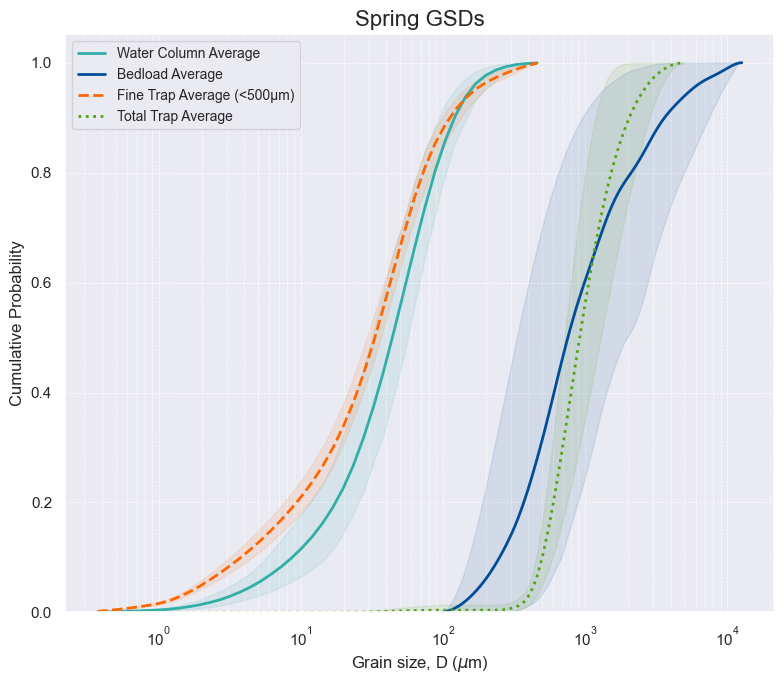

In [15]:
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(8, 7))

# plot the faded distribution between min and max (Water Column)
ax.fill_between(water_SP_cdf['Size '], water_SP_cdf['d10'], water_SP_cdf['d90'], color='#31AFA7', alpha=0.1)
ax.fill_between(bedload_grain_sizes, bedload_cdf['d10'], bedload_cdf['d90'], color="#004E98", alpha=0.1)
ax.fill_between(grain_sizes, trap_SP_cdf['d10'], trap_SP_cdf['d90'], color="#FF6700", alpha=0.1)
ax.fill_between(grain_sizes_full, trap_SP_full_cdf['d10'], trap_SP_full_cdf['d90'], color="#55A314", alpha=0.1)


# plot the average lines
ax.plot(water_SP_cdf['Size '], water_SP_cdf['avg'], color="#31AFA7", linewidth=2, linestyle='-', label='Water Column Average')
ax.plot(bedload_grain_sizes, bedload_cdf['avg'], color="#004E98", linewidth=2, linestyle='-', label='Bedload Average')
ax.plot(grain_sizes, trap_SP_cdf['avg'], color="#FF6700", linewidth=2, linestyle='--', label='Fine Trap Average (<500µm)')
ax.plot(grain_sizes_full, trap_SP_full_cdf['avg'], color="#55A314", linewidth=2, linestyle=':', label='Total Trap Average')


ax.set_title('Spring GSDs', fontsize=16)
xlabel_text = r'Grain size, D ($\mu$m)'
ax.set_xlabel(xlabel_text, fontsize=12)
ax.set_ylabel('Cumulative Probability', fontsize=12)
ax.set_xscale('log') 
ax.set_ylim(bottom=0) # ensure the y-axis starts at 0

ax.legend(loc='upper left', frameon=True, fontsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('plots/full_trap/spring_fulltrapGSD_cdf.png', dpi=500)
plt.show()

Colorblind Version

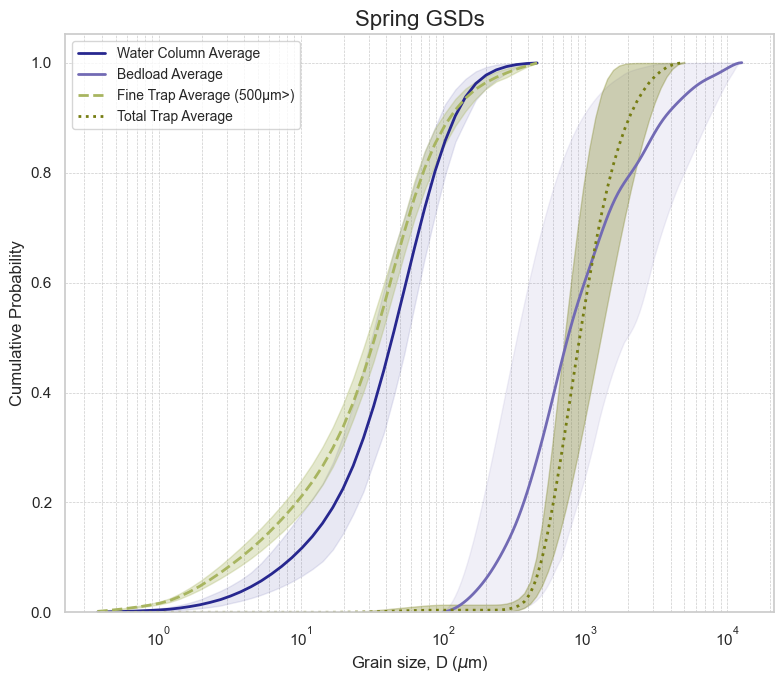

In [16]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(8, 7))

# plot the faded distribution between min and max 
ax.fill_between(water_SP_cdf['Size '], water_SP_cdf['d10'], water_SP_cdf['d90'], color='#27278F', alpha=0.1)
ax.fill_between(bedload_grain_sizes, bedload_cdf['d10'], bedload_cdf['d90'], color="#726AB4", alpha=0.1)
ax.fill_between(grain_sizes, trap_SP_cdf['d10'], trap_SP_cdf['d90'], color="#A8B560", alpha=0.3)
ax.fill_between(grain_sizes_full, trap_SP_full_cdf['d10'], trap_SP_full_cdf['d90'], color="#767D12", alpha=0.3)


# plot the average lines
ax.plot(water_SP_cdf['Size '], water_SP_cdf['avg'], color="#27278F", linewidth=2, linestyle='-', label='Water Column Average')
ax.plot(bedload_grain_sizes, bedload_cdf['avg'], color="#726AB4", linewidth=2, linestyle='-', label='Bedload Average')
ax.plot(grain_sizes, trap_SP_cdf['avg'], color="#A8B560", linewidth=2, linestyle='--', label='Fine Trap Average (500µm>)')
ax.plot(grain_sizes_full, trap_SP_full_cdf['avg'], color="#767D12", linewidth=2, linestyle=':', label='Total Trap Average')


ax.set_title('Spring GSDs', fontsize=16)
xlabel_text = r'Grain size, D ($\mu$m)'
ax.set_xlabel(xlabel_text, fontsize=12)
ax.set_ylabel('Cumulative Probability', fontsize=12)
ax.set_xscale('log') 
ax.set_ylim(bottom=0) # ensure the y-axis starts at 0

ax.legend(loc='upper left', frameon=True, fontsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('plots/full_trap/spring_fulltrapGSD_cdf_colorblind.png', dpi=500)
plt.show()

### Summer

Min and Max

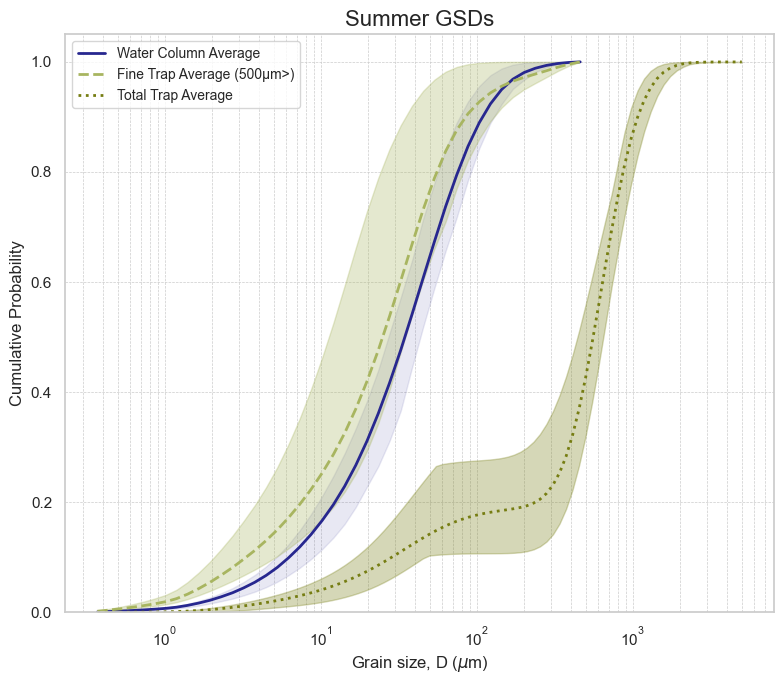

In [17]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(8, 7))

# plot the faded distribution between min and max 
ax.fill_between(water_SM_cdf['Size'], water_SM_cdf['d10'], water_SM_cdf['d90'], color='#27278F', alpha=0.1)
ax.fill_between(grain_sizes, trap_SM_cdf['d10'], trap_SM_cdf['d90'], color="#A8B560", alpha=0.3)
ax.fill_between(grain_sizes_full, trap_SM_full_cdf['d10'], trap_SM_full_cdf['d90'], color="#767D12", alpha=0.3)


# plot the average lines
ax.plot(water_SM_cdf['Size'], water_SM_cdf['avg'], color="#27278F", linewidth=2, linestyle='-', label='Water Column Average')
ax.plot(grain_sizes, trap_SM_cdf['avg'], color="#A8B560", linewidth=2, linestyle='--', label='Fine Trap Average (500µm>)')
ax.plot(grain_sizes_full, trap_SM_full_cdf['avg'], color="#767D12", linewidth=2, linestyle=':', label='Total Trap Average')


ax.set_title('Summer GSDs', fontsize=16)
xlabel_text = r'Grain size, D ($\mu$m)'
ax.set_xlabel(xlabel_text, fontsize=12)
ax.set_ylabel('Cumulative Probability', fontsize=12)
ax.set_xscale('log') 
ax.set_ylim(bottom=0) # ensure the y-axis starts at 0

ax.legend(loc='upper left', frameon=True, fontsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('plots/full_trap/summer_fulltrapGSD_cdf_colorblind.png', dpi=500)
plt.show()

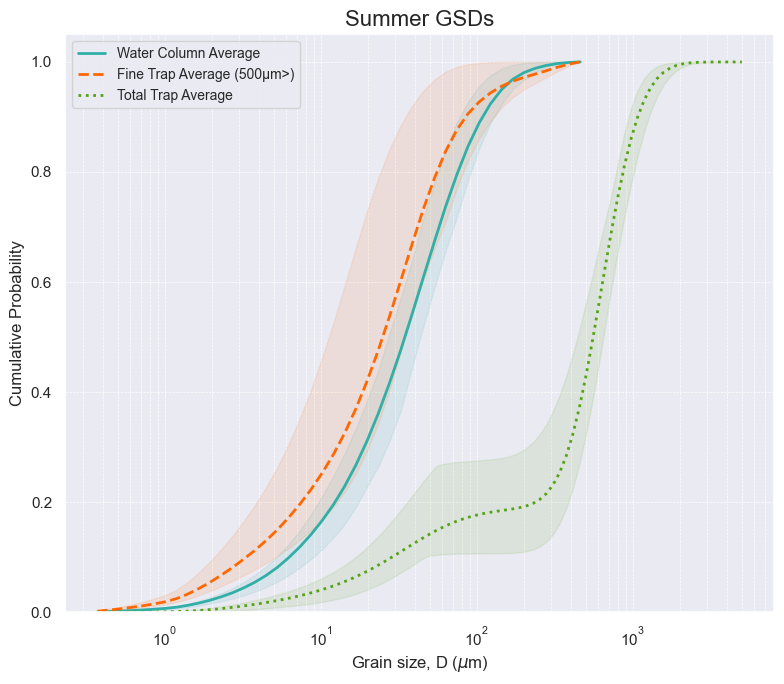

In [18]:
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(8, 7))

# plot the faded distribution between min and max (Water Column)
ax.fill_between(water_SM_cdf['Size'], water_SM_cdf['d10'], water_SM_cdf['d90'], color='#31AFA7', alpha=0.1)
ax.fill_between(grain_sizes, trap_SM_cdf['d10'], trap_SM_cdf['d90'], color="#FF6700", alpha=0.1)
ax.fill_between(grain_sizes_full, trap_SM_full_cdf['d10'], trap_SM_full_cdf['d90'], color="#55A314", alpha=0.1)

# plot the average lines
ax.plot(water_SM_cdf['Size'], water_SM_cdf['avg'], color="#31AFA7", linewidth=2, linestyle='-', label='Water Column Average')
ax.plot(grain_sizes, trap_SM_cdf['avg'], color="#FF6700", linewidth=2, linestyle='--', label='Fine Trap Average (500µm>)')
ax.plot(grain_sizes_full, trap_SM_full_cdf['avg'], color="#55A314", linewidth=2, linestyle=':', label='Total Trap Average')

ax.set_title('Summer GSDs', fontsize=16)
xlabel_text = r'Grain size, D ($\mu$m)'
ax.set_xlabel(xlabel_text, fontsize=12)
ax.set_ylabel('Cumulative Probability', fontsize=12)
ax.set_xscale('log') 
ax.set_ylim(bottom=0) # ensure the y-axis starts at 0

ax.legend(loc='upper left', frameon=True, fontsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('plots/full_trap/summer_fulltrapGSD_cdf.png', dpi=500)
plt.show()

## Subplot

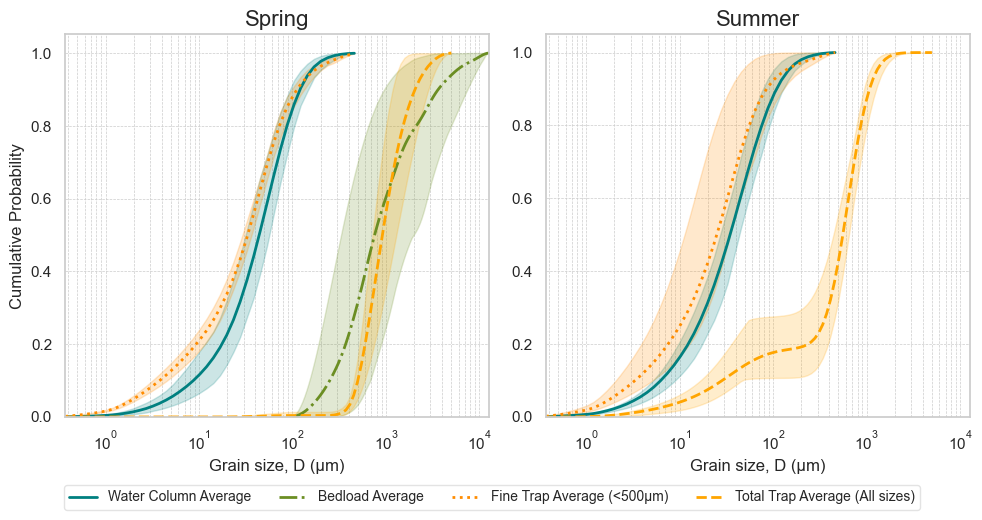

In [ ]:
sns.set(style='whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

water_color = 'teal'
fine_trap_color = 'darkorange'
full_trap_color = 'orange'
bedload_color= 'olivedrab'


# spring plot (left subplot)
ax1.fill_between(water_SP_cdf['Size '], water_SP_cdf['d10'], water_SP_cdf['d90'], color=water_color, alpha=0.2)
ax1.fill_between(bedload_grain_sizes, bedload_cdf['d10'], bedload_cdf['d90'], color=bedload_color, alpha=0.2)
ax1.fill_between(grain_sizes, trap_SP_cdf['d10'], trap_SP_cdf['d90'], color=fine_trap_color, alpha=0.2)
ax1.fill_between(grain_sizes_full, trap_SP_full_cdf['d10'], trap_SP_full_cdf['d90'], color=full_trap_color, alpha=0.2)

ax1.plot(water_SP_cdf['Size '], water_SP_cdf['avg'], color=water_color, linewidth=2, linestyle='-', label='Water Column Average')
ax1.plot(bedload_grain_sizes, bedload_cdf['avg'], color=bedload_color, linewidth=2, linestyle='-.', label='Bedload Average')
ax1.plot(grain_sizes, trap_SP_cdf['avg'], color=fine_trap_color, linewidth=2, linestyle=':', label='Fine Trap Average (<500µm)')
ax1.plot(grain_sizes_full, trap_SP_full_cdf['avg'], color=full_trap_color, linewidth=2, linestyle='--', label='Total Trap Average (All sizes)')

ax1.set_title('Spring', fontsize=16)
ax1.set_xlabel('Grain size, D (µm)', fontsize=12)
ax1.set_ylabel('Cumulative Probability', fontsize=12)
ax1.set_xscale('log') 
ax1.set_ylim(bottom=0)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# summer plot (right subplot)
ax2.fill_between(water_SM_cdf['Size'], water_SM_cdf['d10'], water_SM_cdf['d90'], color=water_color, alpha=0.2)
ax2.fill_between(grain_sizes, trap_SM_cdf['d10'], trap_SM_cdf['d90'], color=fine_trap_color, alpha=0.2)
ax2.fill_between(grain_sizes_full, trap_SM_full_cdf['d10'], trap_SM_full_cdf['d90'], color=full_trap_color, alpha=0.2)

ax2.plot(water_SM_cdf['Size'], water_SM_cdf['avg'], color=water_color, linewidth=2, linestyle='-')
ax2.plot(grain_sizes, trap_SM_cdf['avg'], color=fine_trap_color, linewidth=2, linestyle=':')
ax2.plot(grain_sizes_full, trap_SM_full_cdf['avg'], color=full_trap_color, linewidth=2, linestyle='--')

ax2.set_title('Summer', fontsize=16)
ax2.set_xlabel('Grain size, D (µm)', fontsize=12)
#ax2.set_ylabel('Cumulative Probability', fontsize=12)
ax2.set_xscale('log') 
ax2.set_ylim(bottom=0)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

# horizontal axes having the same limits 
# after plotting and before legend
x_min = min(water_SP_cdf['Size '].min(),
        water_SM_cdf['Size'].min(),
        grain_sizes.min(),
        grain_sizes_full.min(),
        bedload_grain_sizes.min())
x_max = max(water_SP_cdf['Size '].max(),
        water_SM_cdf['Size'].max(),
        grain_sizes.max(),
        grain_sizes_full.max(),
        bedload_grain_sizes.max())

# guard for log-scale (must be > 0)
x_min = max(x_min, 1e-12)
ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)

# create a single legend at the bottom for both plots
# get handles and labels from both subplots
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# combine and remove duplicates while preserving order
handles_dict = {}
labels_dict = {}
for h, l in zip(handles1 + handles2, labels1 + labels2):
    if l not in labels_dict:
        handles_dict[l] = h
        labels_dict[l] = l

# create legend at bottom center
fig.legend(handles_dict.values(), labels_dict.keys(), 
           loc='lower center', bbox_to_anchor=(0.5, -0.05), 
           ncol=4, frameon=True, fontsize=10, edgecolor='gainsboro', facecolor='white')

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for the legend
plt.savefig('plots/full_trap/subplot_fulltrapGSD_cdf_V2.png', dpi=500, bbox_inches='tight')
plt.show()

trying with path effects

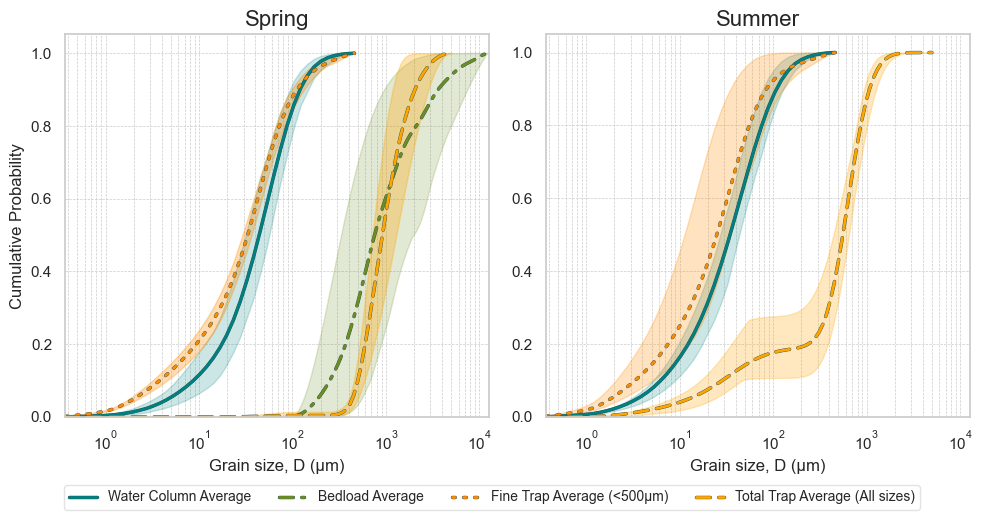

In [76]:
import matplotlib.patheffects as path_effects
sns.set(style='whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

water_color = 'teal'
fine_trap_color = 'darkorange'
full_trap_color = 'orange'
bedload_color= 'olivedrab'


# spring plot (left subplot)
ax1.fill_between(water_SP_cdf['Size '], water_SP_cdf['d10'], water_SP_cdf['d90'], color=water_color, alpha=0.2)
ax1.fill_between(bedload_grain_sizes, bedload_cdf['d10'], bedload_cdf['d90'], color=bedload_color, alpha=0.2)
ax1.fill_between(grain_sizes, trap_SP_cdf['d10'], trap_SP_cdf['d90'], color=fine_trap_color, alpha=0.3)
ax1.fill_between(grain_sizes_full, trap_SP_full_cdf['d10'], trap_SP_full_cdf['d90'], color=full_trap_color, alpha=0.3)

line1 = ax1.plot(water_SP_cdf['Size '], water_SP_cdf['avg'], color=water_color, linewidth=2, linestyle='solid', label='Water Column Average')[0]
line2 = ax1.plot(bedload_grain_sizes, bedload_cdf['avg'], color=bedload_color, linewidth=2, linestyle=(0, (5, 3, 1, 3)), label='Bedload Average')[0] # dash-dot
line3 = ax1.plot(grain_sizes, trap_SP_cdf['avg'], color=fine_trap_color, linewidth=2, linestyle=(0, (1, 3)), label='Fine Trap Average (<500µm)')[0] #  dotted
line4 = ax1.plot(grain_sizes_full, trap_SP_full_cdf['avg'], color=full_trap_color, linewidth=2, linestyle=(0, (5, 3)), label='Total Trap Average (All sizes)')[0] #  dashed

for line in [line1, line2, line3, line4]:
    line.set_path_effects([path_effects.Stroke(linewidth=2.5, foreground='darkslategrey', capstyle='round'), path_effects.Normal()])
    line.set_solid_capstyle('round')
    line.set_solid_joinstyle('round')
    line.set_dash_capstyle('round')
    line.set_dash_joinstyle('round')


ax1.set_title('Spring', fontsize=16)
ax1.set_xlabel('Grain size, D (µm)', fontsize=12)
ax1.set_ylabel('Cumulative Probability', fontsize=12)
ax1.set_xscale('log') 
ax1.set_ylim(bottom=0)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# summer plot (right subplot)
ax2.fill_between(water_SM_cdf['Size'], water_SM_cdf['d10'], water_SM_cdf['d90'], color=water_color, alpha=0.2)
ax2.fill_between(grain_sizes, trap_SM_cdf['d10'], trap_SM_cdf['d90'], color=fine_trap_color, alpha=0.25)
ax2.fill_between(grain_sizes_full, trap_SM_full_cdf['d10'], trap_SM_full_cdf['d90'], color=full_trap_color, alpha=0.25)

line5 = ax2.plot(water_SM_cdf['Size'], water_SM_cdf['avg'], color=water_color, linewidth=2, linestyle='solid')[0]
line6 = ax2.plot(grain_sizes, trap_SM_cdf['avg'], color=fine_trap_color, linewidth=2, linestyle=(0, (1, 3)))[0] #  dotted
line7 = ax2.plot(grain_sizes_full, trap_SM_full_cdf['avg'], color=full_trap_color, linewidth=2, linestyle=(0, (5, 3)))[0] #  dashed

for line in [line5, line6, line7]:
    line.set_path_effects([path_effects.Stroke(linewidth=2.5, foreground='darkslategrey', capstyle='round'), path_effects.Normal()])
    line.set_solid_capstyle('round')
    line.set_solid_joinstyle('round')
    line.set_dash_capstyle('round')
    line.set_dash_joinstyle('round')

ax2.set_title('Summer', fontsize=16)
ax2.set_xlabel('Grain size, D (µm)', fontsize=12)
#ax2.set_ylabel('Cumulative Probability', fontsize=12)
ax2.set_xscale('log') 
ax2.set_ylim(bottom=0)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

# horizontal axes having the same limits 
# after plotting and before legend
x_min = min(water_SP_cdf['Size '].min(),
        water_SM_cdf['Size'].min(),
        grain_sizes.min(),
        grain_sizes_full.min(),
        bedload_grain_sizes.min())
x_max = max(water_SP_cdf['Size '].max(),
        water_SM_cdf['Size'].max(),
        grain_sizes.max(),
        grain_sizes_full.max(),
        bedload_grain_sizes.max())

# guard for log-scale (must be > 0)
x_min = max(x_min, 1e-12)
ax1.set_xlim(x_min, x_max)
ax2.set_xlim(x_min, x_max)

# create a single legend at the bottom for both plots
# get handles and labels from both subplots
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# combine and remove duplicates while preserving order
handles_dict = {}
labels_dict = {}
for h, l in zip(handles1 + handles2, labels1 + labels2):
    if l not in labels_dict:
        handles_dict[l] = h
        labels_dict[l] = l

# create legend at bottom center
fig.legend(handles_dict.values(), labels_dict.keys(), 
           loc='lower center', bbox_to_anchor=(0.5, -0.05), 
           ncol=4, frameon=True, fontsize=10, edgecolor='gainsboro', facecolor='white')

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for the legend
plt.savefig('plots/full_trap/subplot_fulltrapGSD_cdf_V3.png', dpi=900, bbox_inches='tight')
plt.show()

### GSD Metrics

In [20]:
# interpolate bedload to match water column grain sizes
def interpolate_distribution(source_grain_sizes, source_values, target_grain_sizes):
    """Interpolate distribution to match target grain size grid"""
    # create interpolation function
    interp_func = interp1d(source_grain_sizes, source_values, 
                          kind='linear', bounds_error=False, fill_value=0)
    # interpolate to target grid
    return interp_func(target_grain_sizes)

# get grain size arrays
water_SP_grain_sizes = water_SP_cdf.iloc[:, 0].values
bedload_grain_sizes_array = bedload_cdf.iloc[:, 0].values
trap_SP_full_grain_sizes = trap_SP_full_cdf.iloc[:, 0].values
trap_SP_grain_sizes = trap_SP_cdf.iloc[:, 0].values

# interpolate bedload to match water column grid
bedload_avg_interp = interpolate_distribution(bedload_grain_sizes_array, 
                                            bedload_cdf['avg'].values, 
                                            trap_SP_full_grain_sizes)
# water column to match full trap grid
water_SP_avg_interp = interpolate_distribution(water_SP_grain_sizes,
                                                    water_SP_cdf['avg'].values,
                                                    trap_SP_full_grain_sizes)
# fine trap to match full trap grid
trap_SP_avg_interp = interpolate_distribution(trap_SP_grain_sizes, trap_SP_cdf['avg'].values,
                                                    trap_SP_full_grain_sizes)


#### Jensen Shannon Distance

In [21]:
# get grain size arrays
water_SM_grain_sizes = water_SM_cdf.iloc[:, 0].values
trap_SM_full_grain_sizes = trap_SM_full_cdf.iloc[:, 0].values
trap_SM_grain_sizes = trap_SM_cdf.iloc[:, 0].values

# water column to match full trap grid
water_SM_avg_interp = interpolate_distribution(water_SM_grain_sizes,
                                                    water_SM_cdf['avg'].values,
                                                    trap_SM_full_grain_sizes)
# fine trap to match full trap grid
trap_SM_avg_interp = interpolate_distribution(trap_SM_grain_sizes, 
                                                trap_SM_cdf['avg'].values,
                                                    trap_SM_full_grain_sizes)




#### Earth Mover's Distance (EMD)

Spring EMD 


--- Earth Mover's Distance Matrix (EMD) ---
              Water Column  Trap Fine  Trap Full    Bedload
Water Column        0.0000    17.7838  2258.4848  1972.4712
Trap Fine          17.7838     0.0000  2276.2687  1990.2550
Trap Full        2258.4848  2276.2687     0.0000   286.3491
Bedload          1972.4712  1990.2550   286.3491     0.0000
-------------------------------------------------


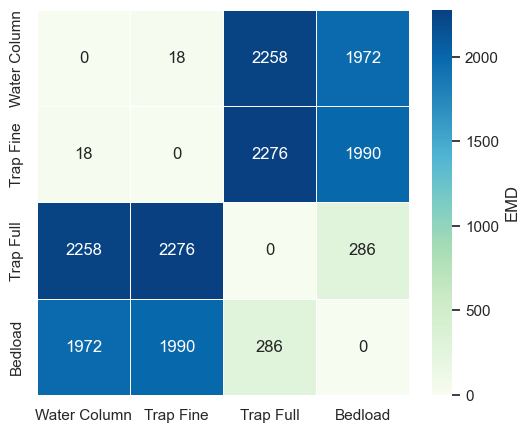

In [22]:
# define the four distributions to compare (using the interpolated versions)
distributions = {
    'Water Column': water_SP_avg_interp,
    'Trap Fine': trap_SP_avg_interp,
    'Trap Full': trap_SP_full_cdf['avg'].values,
        'Bedload': bedload_avg_interp
}

curve_names = list(distributions.keys())
n_curves = len(curve_names)

# initialize an empty matrix for the EMD values
emd_matrix = np.zeros((n_curves, n_curves))

# calculate all pairwise EMD values
for i in range(n_curves):
    for j in range(n_curves):
        dist_i = distributions[curve_names[i]]
        dist_j = distributions[curve_names[j]]
        
        # EMD requires the grain size values as well as the distribution values
        emd_value = wasserstein_distance(trap_SP_full_grain_sizes, trap_SP_full_grain_sizes, 
                                        dist_i, dist_j)
        emd_matrix[i, j] = emd_value

# convert the NumPy array to a Pandas DataFrame for easy labeling and plotting
emd_spring = pd.DataFrame(emd_matrix, index=curve_names, columns=curve_names)

# print the resulting EMD matrix
print("\n--- Earth Mover's Distance Matrix (EMD) ---")
print(emd_spring.round(4))
print("-------------------------------------------------")


# plot heatmap
plt.figure(figsize=(6, 5))
heatmap = sns.heatmap(
    emd_spring,
    annot=True,             
    fmt=".0f",             
    cmap="GnBu",       
    linewidths=.5,           
    linecolor='white',
    cbar_kws={'label': 'EMD'} # Label the color bar
)

emd_spring.to_csv('emd_matrix_spring.csv')
plt.savefig('plots/full_trap/emd_heatmap_spring.png', dpi=300, bbox_inches='tight')

Summer EMD 


--- Earth Mover's Distance Matrix (EMD) ---
              Water Column  Trap Fine  Trap Full
Water Column        0.0000    14.9098  1550.6368
Trap Fine          14.9098     0.0000  1565.5466
Trap Full        1550.6368  1565.5466     0.0000
-------------------------------------------------


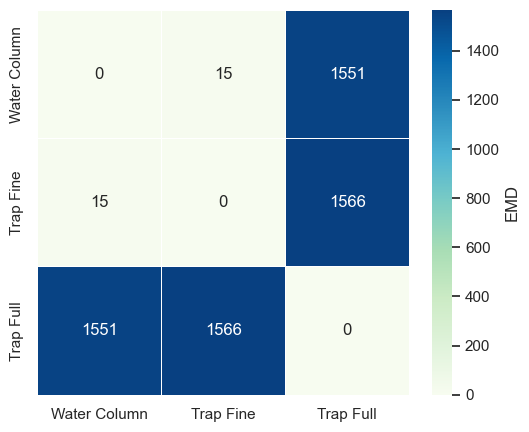

In [23]:
# define the four distributions to compare (using the interpolated versions)
distributions = {
    'Water Column': water_SM_avg_interp,
    'Trap Fine': trap_SM_avg_interp,
    'Trap Full': trap_SM_full_cdf['avg'].values,
}

curve_names = list(distributions.keys())
n_curves = len(curve_names)

# initialize an empty matrix for the EMD values
emd_matrix = np.zeros((n_curves, n_curves))

# calculate all pairwise EMD values
for i in range(n_curves):
    for j in range(n_curves):
        dist_i = distributions[curve_names[i]]
        dist_j = distributions[curve_names[j]]
        
        # EMD requires the grain size values as well as the distribution values
        emd_value = wasserstein_distance(trap_SM_full_grain_sizes, trap_SM_full_grain_sizes, 
                                        dist_i, dist_j)
        emd_matrix[i, j] = emd_value

# convert the NumPy array to a Pandas DataFrame for easy labeling and plotting
emd_summer = pd.DataFrame(emd_matrix, index=curve_names, columns=curve_names)

# print the resulting EMD matrix
print("\n--- Earth Mover's Distance Matrix (EMD) ---")
print(emd_summer.round(4))
print("-------------------------------------------------")


# plot heatmap
plt.figure(figsize=(6, 5))
heatmap = sns.heatmap(
    emd_summer,
    annot=True,             
    fmt=".0f",             
    cmap="GnBu",       
    linewidths=.5,           
    linecolor='white',
    cbar_kws={'label': 'EMD'} # Label the color bar
)

emd_summer.to_csv('emd_matrix_summer.csv')
plt.savefig('plots/full_trap/emd_heatmap_summer.png', dpi=300, bbox_inches='tight')


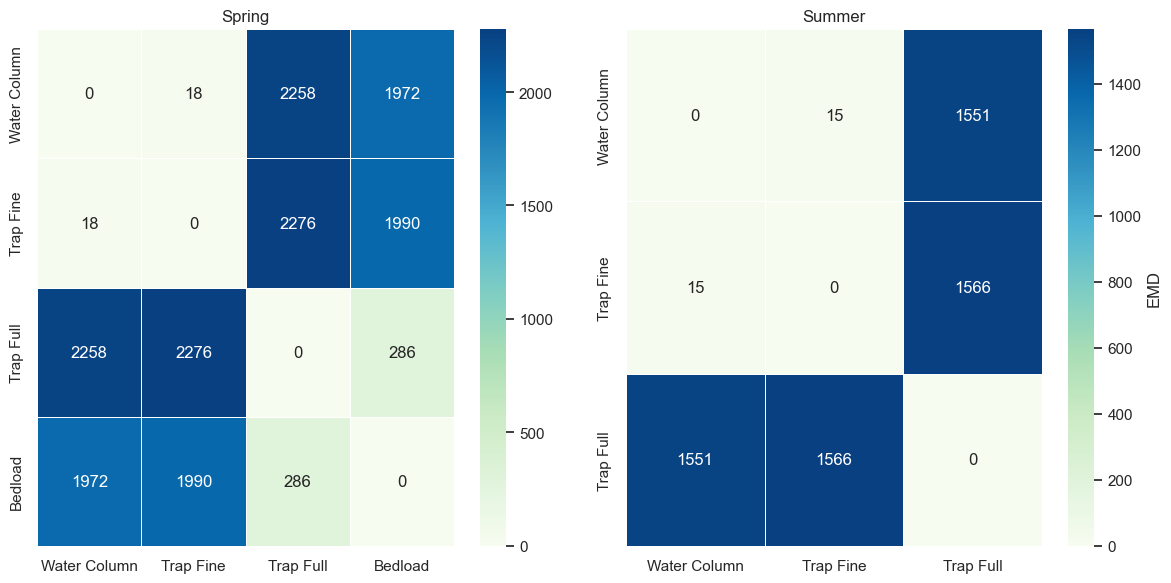

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create figure with two subplots (not sharing axes)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# --- Spring heatmap (4x4) ---
sns.heatmap(
    emd_spring,
    annot=True,
    fmt=".0f",
    cmap="GnBu",
    linewidths=.5,
    linecolor='white',
    ax=axes[0]
)
axes[0].set_title("Spring", fontsize=12)

# --- Summer heatmap (3x3) ---
sns.heatmap(
    emd_summer,
    annot=True,
    fmt=".0f",
    cmap="GnBu",
    linewidths=.5,
    linecolor='white',
    cbar_kws={'label': 'EMD'},
    ax=axes[1]
)
axes[1].set_title("Summer", fontsize=12)

# Adjust spacing so labels don’t overlap
plt.tight_layout(w_pad=2)

# Save combined figure
plt.savefig('plots/full_trap/emd_heatmap_spring_summer_subplot.png', dpi=300, bbox_inches='tight')

plt.show()



### Calculating Average Silt and Clay Calculations

In [25]:
# Total water column concentration (mg/L)
# spring
avg_sp_conc = 8.76
min_sp_conc = 1.56
max_sp_conc = 45.00
# summer 
avg_sm_conc = 38.00
min_sm_conc = 12.56
max_sm_conc = 110.00

In [26]:
# calculating the average silt and clay percentage from CDF 
# FROM WATER COLUMNS
silt_clay_sp_percent = water_SP_cdf.loc[water_SP_cdf['Size '] <= 63.11, 'avg'].max() # spring
silt_clay_sm_percent = water_SM_cdf.loc[water_SM_cdf['Size'] <= 63.11, 'avg'].max() # summer
print(f"Spring WC Silt and Clay Percentage (avg): {silt_clay_sp_percent*100:.2f}%")
print(f"Summer WC Silt and Clay Percentage (avg): {silt_clay_sm_percent*100:.2f}%")

Spring WC Silt and Clay Percentage (avg): 66.34%
Summer WC Silt and Clay Percentage (avg): 73.69%


In [27]:
# print the concentrations of silt and clay in mg/L
print("\n--- Silt and Clay Concentrations ---")
print(f"SP Silt and Clay (avg): {avg_sp_conc * silt_clay_sp_percent:.2f} mg/L")
print(f"SP Silt and Clay (min): {min_sp_conc * silt_clay_sp_percent:.2f} mg/L")
print(f"SP Silt and Clay (max): {max_sp_conc * silt_clay_sp_percent:.2f} mg/L")
    
print(f"Summer Silt and Clay (avg): {avg_sm_conc * silt_clay_sm_percent:.2f} mg/L")
print(f"Summer WC Silt and Clay (min): {min_sm_conc * silt_clay_sm_percent:.2f} mg/L")
print(f"Summer WC Silt and Clay (max): {max_sm_conc * silt_clay_sm_percent:.2f} mg/L")


--- Silt and Clay Concentrations ---
SP Silt and Clay (avg): 5.81 mg/L
SP Silt and Clay (min): 1.03 mg/L
SP Silt and Clay (max): 29.85 mg/L
Summer Silt and Clay (avg): 28.00 mg/L
Summer WC Silt and Clay (min): 9.26 mg/L
Summer WC Silt and Clay (max): 81.06 mg/L
